# autoArrange
## Implementing 'Balence-Based Photo Posting'

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

modelLayer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", output_shape=[1280],
                   trainable=False)

open image as grayscale

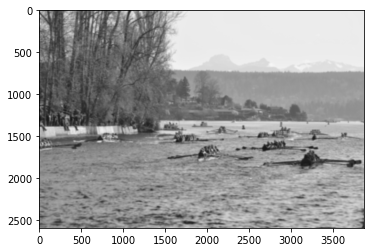

In [35]:
#get img, read as grayscale
img = cv2.imread('test.jpg', cv2.IMREAD_COLOR)
img_gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#show our test subject...
plimg = cv2.cvtColor(img_gr, cv2.COLOR_BGR2RGB)
plt.imshow(plimg, interpolation="bicubic")
plt.show()

Calculate DCM

In [36]:
w, h = img_gr.shape

#avg center of mass for x
m_x = cv2.reduce(img_gr, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S).flatten()

mr_x = np.sum(np.arange(1, w + 1) * m_x)

b_x = mr_x / np.sum(m_x)

#avg center of mass for y
m_y = cv2.reduce(img_gr, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S).flatten()

mr_y = np.sum(np.arange(1, h + 1) * m_y)

b_y = mr_y / np.sum(m_y)

In [37]:
dx = 0.5 - (b_x / w)
dy = 0.5 - (b_y / h)

ba_col = ((dx ** 2 + dy ** 2) ** 0.5) / 0.5
ba_col = ba_col * 100

display(ba_col)

10.951869047114297

Make DCM into Python function

In [17]:
def ba_col(img):
    img_gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    w, h = img_gr.shape

    #avg center of mass for x
    m_x = cv2.reduce(img_gr, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S).flatten()

    mr_x = np.sum(np.arange(1, w + 1) * m_x)

    b_x = mr_x / np.sum(m_x)

    #avg center of mass for y
    m_y = cv2.reduce(img_gr, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S).flatten()

    mr_y = np.sum(np.arange(1, h + 1) * m_y)

    b_y = mr_y / np.sum(m_y)
    
    dx = 0.5 - (b_x / w)
    dy = 0.5 - (b_y / h)

    ba_col = ((dx ** 2 + dy ** 2) ** 0.5) / 0.5
    ba_col = ba_col * 100
    
    return ba_col

Implement feature vector part of poster

In [24]:
#use mobileNet instead of vcc-16

m = tf.keras.Sequential([
    modelLayer # Can be True, see below.
])
m.build([None, 224, 224, 3])

In [39]:
#reshape and run to get feature vector
def pvec(img):
    mini = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    mini = mini / 255
    mini = mini.reshape((1, 224, 224, 3))
    return m.predict(mini)

(1, 224, 224, 3)

array([[0.33707234, 0.        , 0.6582631 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

Use feature vectors as input to MobileNet to make image arrangement scoring function

In [23]:
def ba_con(img1, img2):
    def pvec(img):
        mini = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
        mini = mini / 255
        mini = mini.reshape((1, 224, 224, 3))
        return m.predict(mini)
    vec = pvec(img1) - pvec(img2)
    return np.linalg.norm(vec)

In [ ]:
#let's try and arrange nine images...
#actually fill this in later with nine images...
M = 4

total = 0
for i1, i2 in pairs:
    vec = pvec(i1) - pvec(i2)
    total += np.linalg.norm(vec)

ba_con = (1/M) * total

l = 0.1

mea_ba = ba_col + l * ba_con

Manually create and score an arrangement of images

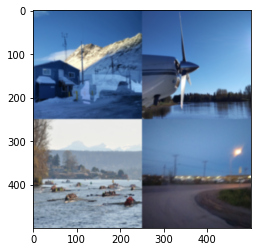

31.626430584258053

In [33]:
#make an interesting composition
l = 1.0

knit = []
for i in range(0, 4):
    process = cv2.imread('batch1/%d.jpg' % (i), cv2.IMREAD_COLOR)
    process = cv2.resize(process, (250, 250), interpolation = cv2.INTER_AREA)
    knit.append(process)
    
p2 = np.zeros((500, 500, 3), np.uint8)
p2[:250, :250] = knit[0]
p2[250:, :250] = knit[1]
p2[:250, 250:] = knit[2]
p2[250:, 250:] = knit[3]

plimg = cv2.cvtColor(p2, cv2.COLOR_BGR2RGB)
plt.imshow(plimg, interpolation="bicubic")
plt.show()

#do this by hand for now.
bcsum = ba_con(knit[0], knit[1])
bcsum += ba_con(knit[0], knit[2])
bcsum += ba_con(knit[0], knit[3])
bcsum += ba_con(knit[1], knit[2])
bcsum += ba_con(knit[1], knit[3])
bcsum += ba_con(knit[2], knit[3])

bcsum = (1/6) * bcsum

mean_ba = ba_col(p2) + 1.0 * bcsum

display(mean_ba)

Make final version of code for 2x2 image, smaller values are more aesthetically pleasing

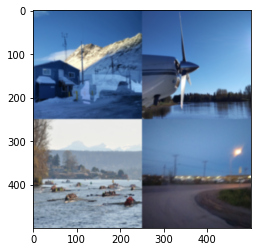

31.626430584258053

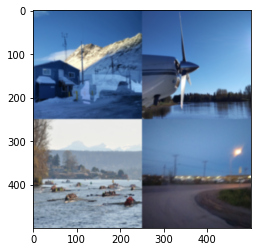

31.626430584258053

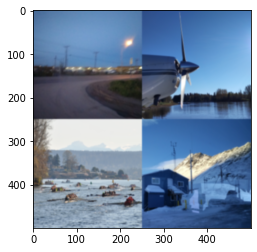

31.473941079020207

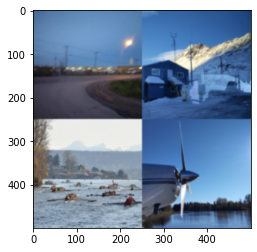

33.28700548992181

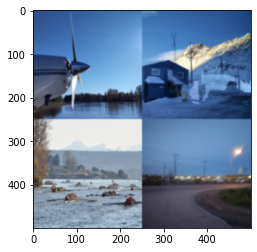

34.20638649397186

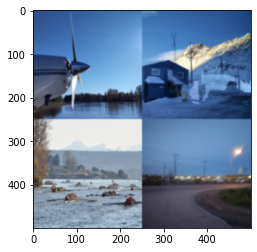

34.20638649397186

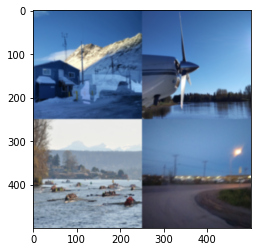

31.626430584258053

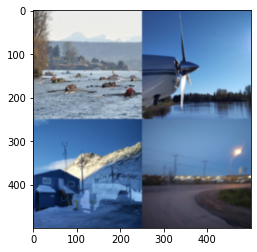

40.58314183609595

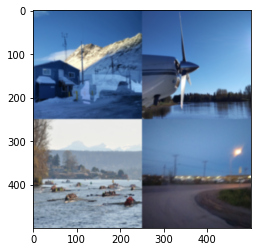

31.626430584258053

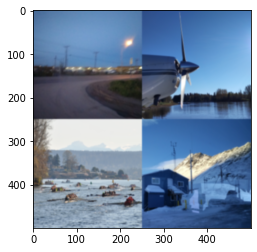

31.473941079020207

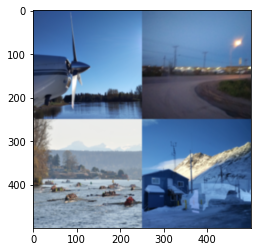

34.28550261670744

In [34]:
def grade(p2, knit, l = 1.0):
    plimg = cv2.cvtColor(p2, cv2.COLOR_BGR2RGB)
    plt.imshow(plimg, interpolation="bicubic")
    plt.show()

    #do this by hand for now.
    bcsum = ba_con(knit[0], knit[1])
    bcsum += ba_con(knit[0], knit[2])
    bcsum += ba_con(knit[0], knit[3])
    bcsum += ba_con(knit[1], knit[2])
    bcsum += ba_con(knit[1], knit[3])
    bcsum += ba_con(knit[2], knit[3])

    bcsum = (1/6) * bcsum

    mean_ba = ba_col(p2) + 1.0 * bcsum

    return mean_ba

#only have point mutate for now...
def point_mutate(knit):
    #random
    x1 = np.random.randint(low=0, high=4)
    x2 = np.random.randint(low=0, high=4)
    
    #cross over
    temp = knit[x1]
    knit[x1] = knit[x2]
    knit[x2] = temp
    
    #display result
    p2 = np.zeros((500, 500, 3), np.uint8)
    p2[:250, :250] = knit[0]
    p2[250:, :250] = knit[1]
    p2[:250, 250:] = knit[2]
    p2[250:, 250:] = knit[3]
    
    return p2, knit

display(grade(p2, knit))


for i in range(0, 10):
    p2, knit = point_mutate(knit)
    display(grade(p2, knit))

todo: <br/>
make optimization happen automatically <br/>
get more images by using autocompcam to generate lots of high quality crops on different grid systems
build and evaluate...